In [1]:
import os
import warnings
from glob import glob
from collections import namedtuple

import cartopy.crs as ccrs
import geopandas
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt
import rasterio
import rioxarray
import shapely.geometry

In [100]:
%matplotlib inline

In [2]:
def dict_as_namedtuple(data, name="NamedTuple"):
    """Helper to create namedtuple from any dict
    """
    type_ = namedtuple(name, data.keys())
    return type_(**data)

In [3]:
# add "name": '#color' to dictionary
# then use COLORS.background, COLORS.whatever  ...
d = {
    "background": '#bfc0bf',
    "lightgrey": '#e4e4e3',
    "grey": '#dededc',
    "darkgrey": '#969696',
    "water": '#87cefa',
    "blue1": '#c6dbef',
    "blue2": '#6baed6',
    "blue3": '#2171b5',
    "blue4": '#08306b',
    "white": '#ffffff',
    "transparent": '#00000000',
}
COLORS = dict_as_namedtuple(d, name="Palette")
COLORS

Palette(background='#bfc0bf', lightgrey='#e4e4e3', grey='#dededc', darkgrey='#969696', water='#87cefa', blue1='#c6dbef', blue2='#6baed6', blue3='#2171b5', blue4='#08306b', white='#ffffff', transparent='#00000000')

In [4]:
def read_file(path, **kwd):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = geopandas.read_file(path, **kwd)
    return data

In [135]:
glob('incoming_data/Hazards/aqueduct_flood/*/*river*hist*1000*')

['incoming_data/Hazards/aqueduct_flood/Kenya/inunriver_historical_000000000WATCH_1980_rp01000.prj',
 'incoming_data/Hazards/aqueduct_flood/Kenya/inunriver_historical_000000000WATCH_1980_rp01000.tif.aux.xml',
 'incoming_data/Hazards/aqueduct_flood/Kenya/inunriver_historical_000000000WATCH_1980_rp01000.tif',
 'incoming_data/Hazards/aqueduct_flood/Zambia/inunriver_historical_000000000WATCH_1980_rp01000.prj',
 'incoming_data/Hazards/aqueduct_flood/Zambia/inunriver_historical_000000000WATCH_1980_rp01000.tif.aux.xml',
 'incoming_data/Hazards/aqueduct_flood/Zambia/inunriver_historical_000000000WATCH_1980_rp01000.tif',
 'incoming_data/Hazards/aqueduct_flood/Tanzania/inunriver_historical_000000000WATCH_1980_rp01000.tif.aux.xml',
 'incoming_data/Hazards/aqueduct_flood/Tanzania/inunriver_historical_000000000WATCH_1980_rp01000.tif',
 'incoming_data/Hazards/aqueduct_flood/Tanzania/inunriver_historical_000000000WATCH_1980_rp01000.prj',
 'incoming_data/Hazards/aqueduct_flood/Uganda/inunriver_historic

In [6]:
df = read_file('incoming_data/Admin_boundaries/gadm36_levels.gpkg', layer='level0')
df.head(2)

,GID_0,NAME_0,geometry
0,ABW,Aruba,"MULTIPOLYGON (((-69.97820 12.46986, -69.97847 ..."
1,AFG,Afghanistan,"MULTIPOLYGON (((68.52644 31.75435, 68.53852 31..."


In [7]:
def df_bounds(df):
    min_bounds = df.bounds.min()
    max_bounds = df.bounds.max()
    minx = min_bounds.minx
    miny = min_bounds.miny
    maxx = max_bounds.maxx
    maxy = max_bounds.maxy
    return (minx, miny, maxx, maxy)

def pad_bounds(bounds, pad=0.1):
    minx, miny, maxx, maxy = bounds
    return (minx - pad, miny - pad, maxx + pad, maxy + pad)

In [98]:
def get_axes(minx, maxx, miny, maxy, ax_proj):
    """Get map axes
    """
    fig, ax = plt.subplots(
        figsize=(8, 8),
        dpi=150,
        subplot_kw={'projection': ax_proj})
    
    # expect bounds in this CRS
    bounds_proj = ccrs.PlateCarree()
    ax.set_extent((minx, maxx, miny, maxy), crs=bounds_proj)
    ax.patch.set_facecolor(COLORS.background)

    return fig, ax

In [89]:
def plot_basemap(ax, states, regions, lakes, plot_regions=False):
    """Plot countries and regions background
    """
    states.plot(ax=ax, edgecolor=COLORS.transparent, facecolor=COLORS.lightgrey, zorder=1)
    states.plot(ax=ax, edgecolor=COLORS.white, linewidth=0.5, facecolor=COLORS.transparent, zorder=4)
    
    if plot_regions:
        regions.plot(ax=ax, edgecolor=COLORS.transparent, facecolor=COLORS.grey, zorder=2)
        regions.plot(ax=ax, edgecolor=COLORS.white, linewidth=0.2, facecolor=COLORS.transparent, zorder=5)
       
    lakes.plot(ax=ax, edgecolor='none', facecolor=COLORS.water, zorder=3)
    
    return ax

In [74]:
states = read_file(
    'incoming_data/Admin_boundaries/gadm36_levels.gpkg', layer='level0')
region = states[states.GID_0.isin(['KEN', 'UGA', 'TZA', 'ZMB'])]
minx, miny, maxx, maxy = pad_bounds(df_bounds(region), pad=0.2)
states = states.cx[minx:maxx, miny:maxy]

In [11]:
regions = regions = read_file(
    'incoming_data/Admin_boundaries/gadm36_levels.gpkg', layer='level1')
regions = regions[regions.GID_0.isin(['KEN', 'UGA', 'TZA', 'ZMB'])]

In [12]:
lakes = read_file('incoming_data/naturalearth/ne_10m_lakes.shp')
lakes = lakes.cx[minx:maxx, miny:maxy]

In [75]:
ax_crs = 3857
ax_proj = ccrs.epsg(ax_crs)
states = states.to_crs(ax_crs)
regions = regions.to_crs(ax_crs)
lakes = lakes.to_crs(ax_crs)

In [77]:
def centroid_labels(df, label_col="text"):
    df = geopandas.GeoDataFrame({
        "text": df[label_col],
        "geometry": df.geometry.centroid
    })
    return df[~df.geometry.is_empty]

def plot_labels(ax, ax_proj, labels, size=6, alpha=1, horizontalalignment='center', zorder=10):
    """Plot labels.
    
    `labels` is a GeoDataFrame with ["text", "geometry"] columns,
    already projected to the `ax` CRS.
    """
    for label in labels.itertuples():
        text = label.text
        x = label.geometry.x
        y = label.geometry.y
        ax.text(
            x,
            y,
            text,
            size=size,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            zorder=zorder,
            transform=ax_proj
        )

In [115]:
draft_labels = centroid_labels(states, label_col="NAME_0")
draft_labels.head(2)

,text,geometry
2,Angola,POINT (1953869.589 -1386255.242)
17,Burundi,POINT (3327313.647 -375145.786)


In [116]:
draft_labels.to_file("incoming_data/draft_labels.gpkg", driver="GPKG")

In [126]:
labels = read_file("incoming_data/labels.gpkg")

In [127]:
labels

,text,geometry
0,Angola,POINT (2524963.583 -1341469.844)
1,Burundi,POINT (3327313.647 -375145.786)
2,Democratic Republic of the Congo,POINT (3244626.616 -763442.620)
3,Ethiopia,POINT (4308809.186 484483.703)
4,Kenya,POINT (4212954.180 61646.500)
5,Mozambique,POINT (4216937.309 -1601773.494)
6,Malawi,POINT (3807341.860 -1548181.566)
7,Rwanda,POINT (3331390.119 -222752.591)
8,Somalia,POINT (4710748.646 201212.083)
9,South Sudan,POINT (3608286.127 488311.698)


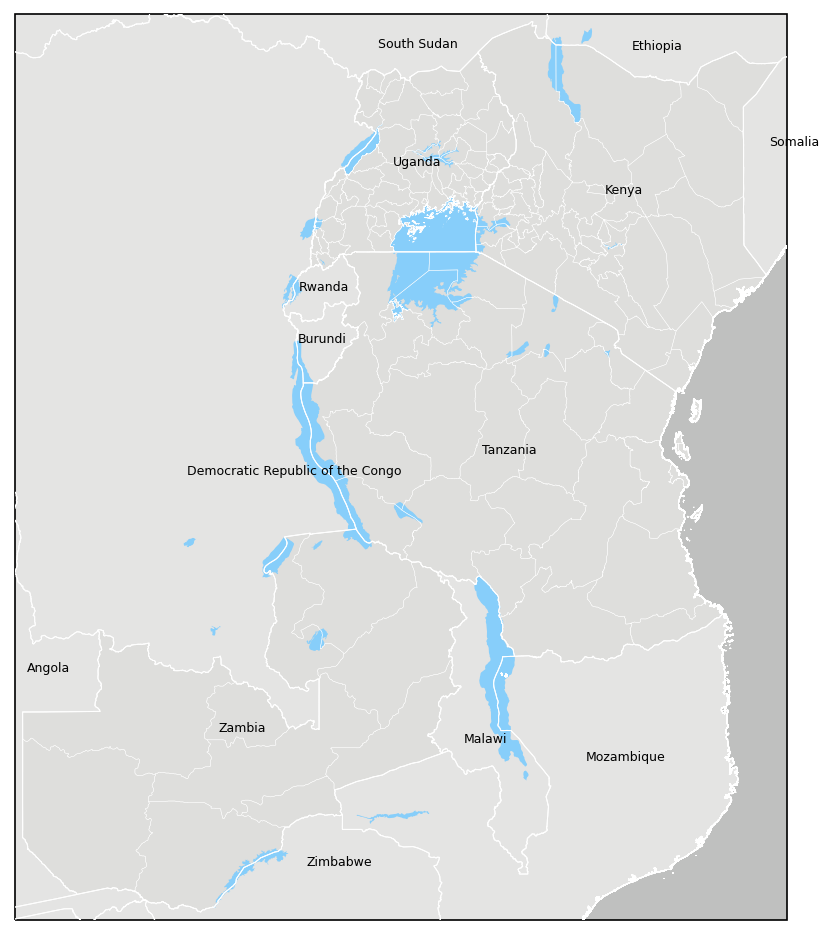

In [128]:
fig, ax = get_axes(minx, maxx, miny, maxy, ax_proj)
plot_basemap(ax, states, regions, lakes, plot_regions=True)
plot_labels(ax, ax_proj, labels)

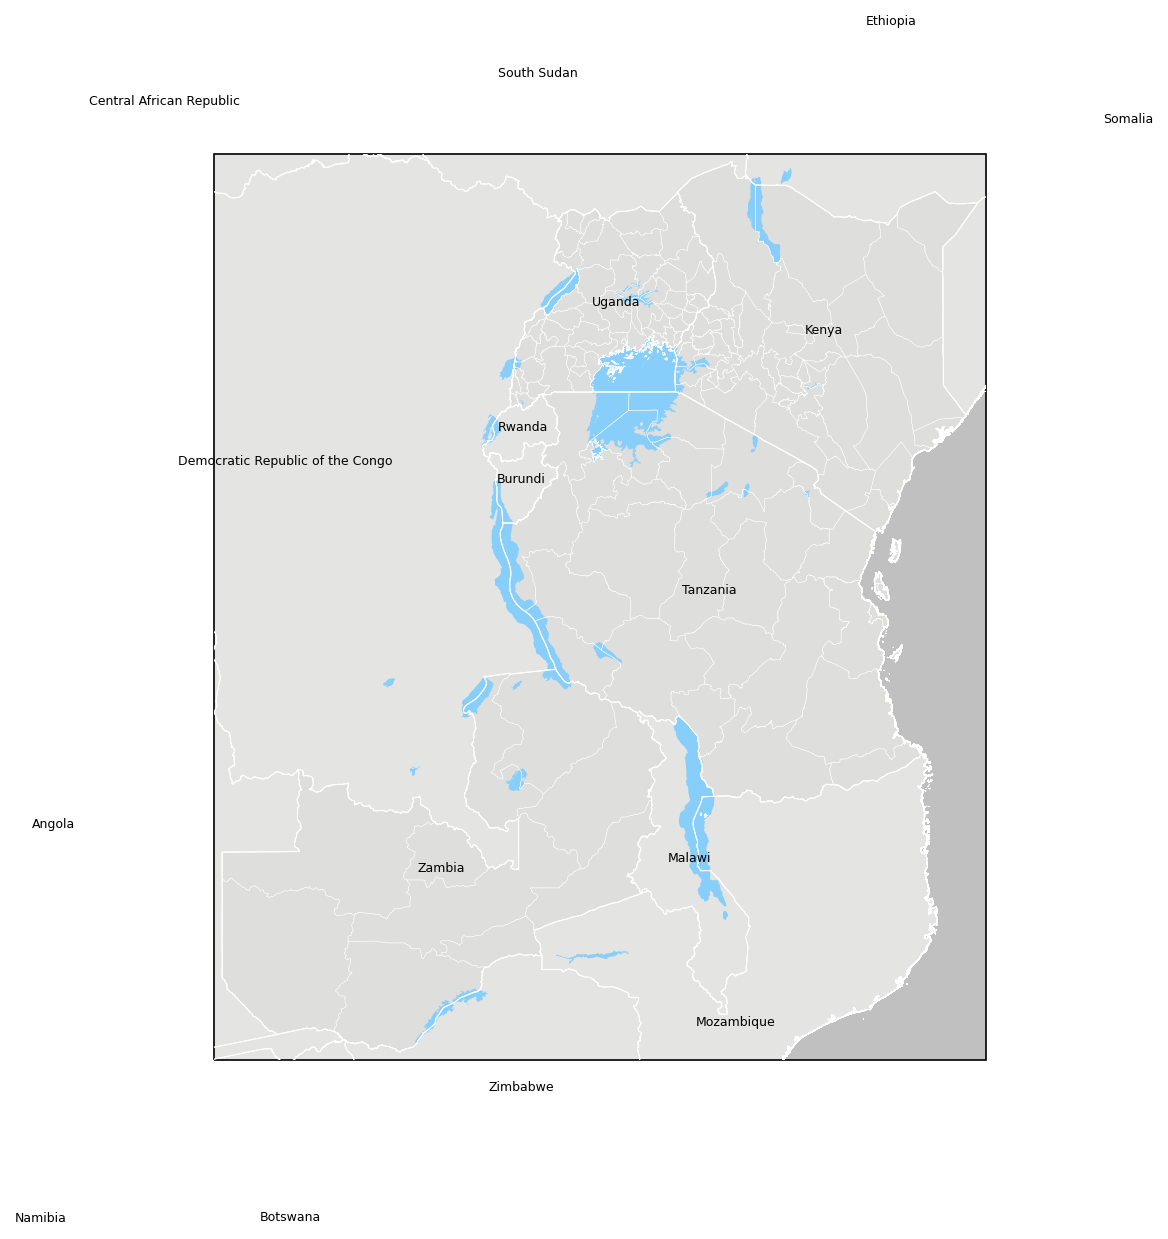

In [124]:
fig

In [95]:
plt.savefig('admin_map.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.show()